# RAG with Recursive Abstractive Processing for Tree-Organized Retrival (RAPTOR)

## Load Env variables

In [1]:
import os
from dotenv import load_dotenv

load_dotenv('app/src/shared/.env')
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [2]:
import sklearn
print(sklearn.show_versions())


System:
    python: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]
executable: /opt/homebrew/anaconda3/envs/tcc/bin/python
   machine: macOS-14.2.1-arm64-arm-64bit

Python dependencies:
      sklearn: 1.5.0
          pip: 23.3.1
   setuptools: 70.1.0
        numpy: 1.26.4
        scipy: 1.13.1
       Cython: None
       pandas: 2.2.1
   matplotlib: 3.9.0
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 8
         prefix: libopenblas
       filepath: /opt/homebrew/anaconda3/envs/tcc/lib/python3.12/site-packages/numpy/.dylibs/libopenblas64_.0.dylib
        version: 0.3.23.dev
threading_layer: pthreads
   architecture: armv8

       user_api: blas
   internal_api: openblas
    num_threads: 8
         prefix: libopenblas
       filepath: /opt/homebrew/anaconda3/envs/tcc/lib/libopenblasp-r0.3.21.dylib
        version: 0.3.21
threading_layer: pthreads
   

## Define the LLM model and embedding parameters

In [92]:
from langchain_google_genai import GoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI


# model = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
embd = OpenAIEmbeddings(model="text-embedding-3-large")


model = GoogleGenerativeAI(model="gemini-1.5-pro", temperature=0) # type: ignore
# embd = GoogleGenerativeAIEmbeddings(model="models/embedding-001",
#                                     task_type="retrieval_document") # type: ignore


## Set a logger to track all the processes

In [4]:
import logging
# Configure logging 
logging.basicConfig(filename='processing.log', level=logging.INFO, format='%(asctime)s %(message)s')

## Document loaders - Load Sources

### Loading the pdf docs with PyPDF loader

In [5]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from typing import List, Dict
import os
import logging
from concurrent.futures import ThreadPoolExecutor
from typing import List


# Configure logging 
logging.basicConfig(filename='pdf_processing.log', level=logging.INFO, format='%(asctime)s %(message)s')

# Função de carregamento de PDF
def load_pdf_file(pdf_folder_path: str, filename: str) -> List[Document]:
    """Processes a single PDF file and returns the extracted elements.

    Logs information and errors during processing.
    """
    try:
        pages = []
        loader = PyPDFLoader(os.path.join(pdf_folder_path, filename))
        pages = loader.load()
        logging.info(f"Successfully processed PDF: {filename}")
        return pages
    except Exception as e:  # Catch specific PDF processing errors
        logging.error(f"Error processing PDF: {filename} - {e}")
        return []
    
    # Função para processar múltiplos PDFs
def process_multiple_pdfs(pdf_folder_path: str, max_workers: int = 8) -> Dict[str, List]:
    """Processes all PDF files within a specified folder using ThreadPoolExecutor.

    Logs information and errors during processing.
    """
    all_elements = {}
    filenames = [filename for filename in os.listdir(pdf_folder_path) if filename.endswith(".pdf")]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Mapeando cada filename para a função load_pdf_file com a pasta de PDFs
        future_to_filename = {executor.submit(load_pdf_file, pdf_folder_path, filename): filename for filename in filenames}

        for future in future_to_filename:
            filename = future_to_filename[future]
            try:
                result = future.result()
                all_elements[filename] = result  # Armazenando o resultado no dicionário
            except Exception as e:
                logging.error(f"Error processing PDF: {filename} - {e}")
                all_elements[filename] = []

    return all_elements


pdf_folder_path = "app/src/database/pdf"
pdf_results = process_multiple_pdfs(pdf_folder_path)

for filename, elements in pdf_results.items():
    print(f"PDF: {filename}, Pages: {len(elements)}")

PDF: NBR_5419_1.pdf, Pages: 77
PDF: NBR_5419_3.pdf, Pages: 61
PDF: ABNT_NBR_IEC_60079_14.pdf, Pages: 94
PDF: NBR_5419_2.pdf, Pages: 116
PDF: NBR_5410.pdf, Pages: 217
PDF: NBR_5413.pdf, Pages: 13
PDF: NBR_5419_4.pdf, Pages: 99
PDF: nr-10.pdf, Pages: 18
PDF: NBR_14039.pdf, Pages: 102
PDF: NBR_13570.pdf, Pages: 5
PDF: NBR_10898.pdf, Pages: 44
PDF: NBR_15514.pdf, Pages: 30
PDF: NBR_16280.pdf, Pages: 17


## Visualization of the texts data

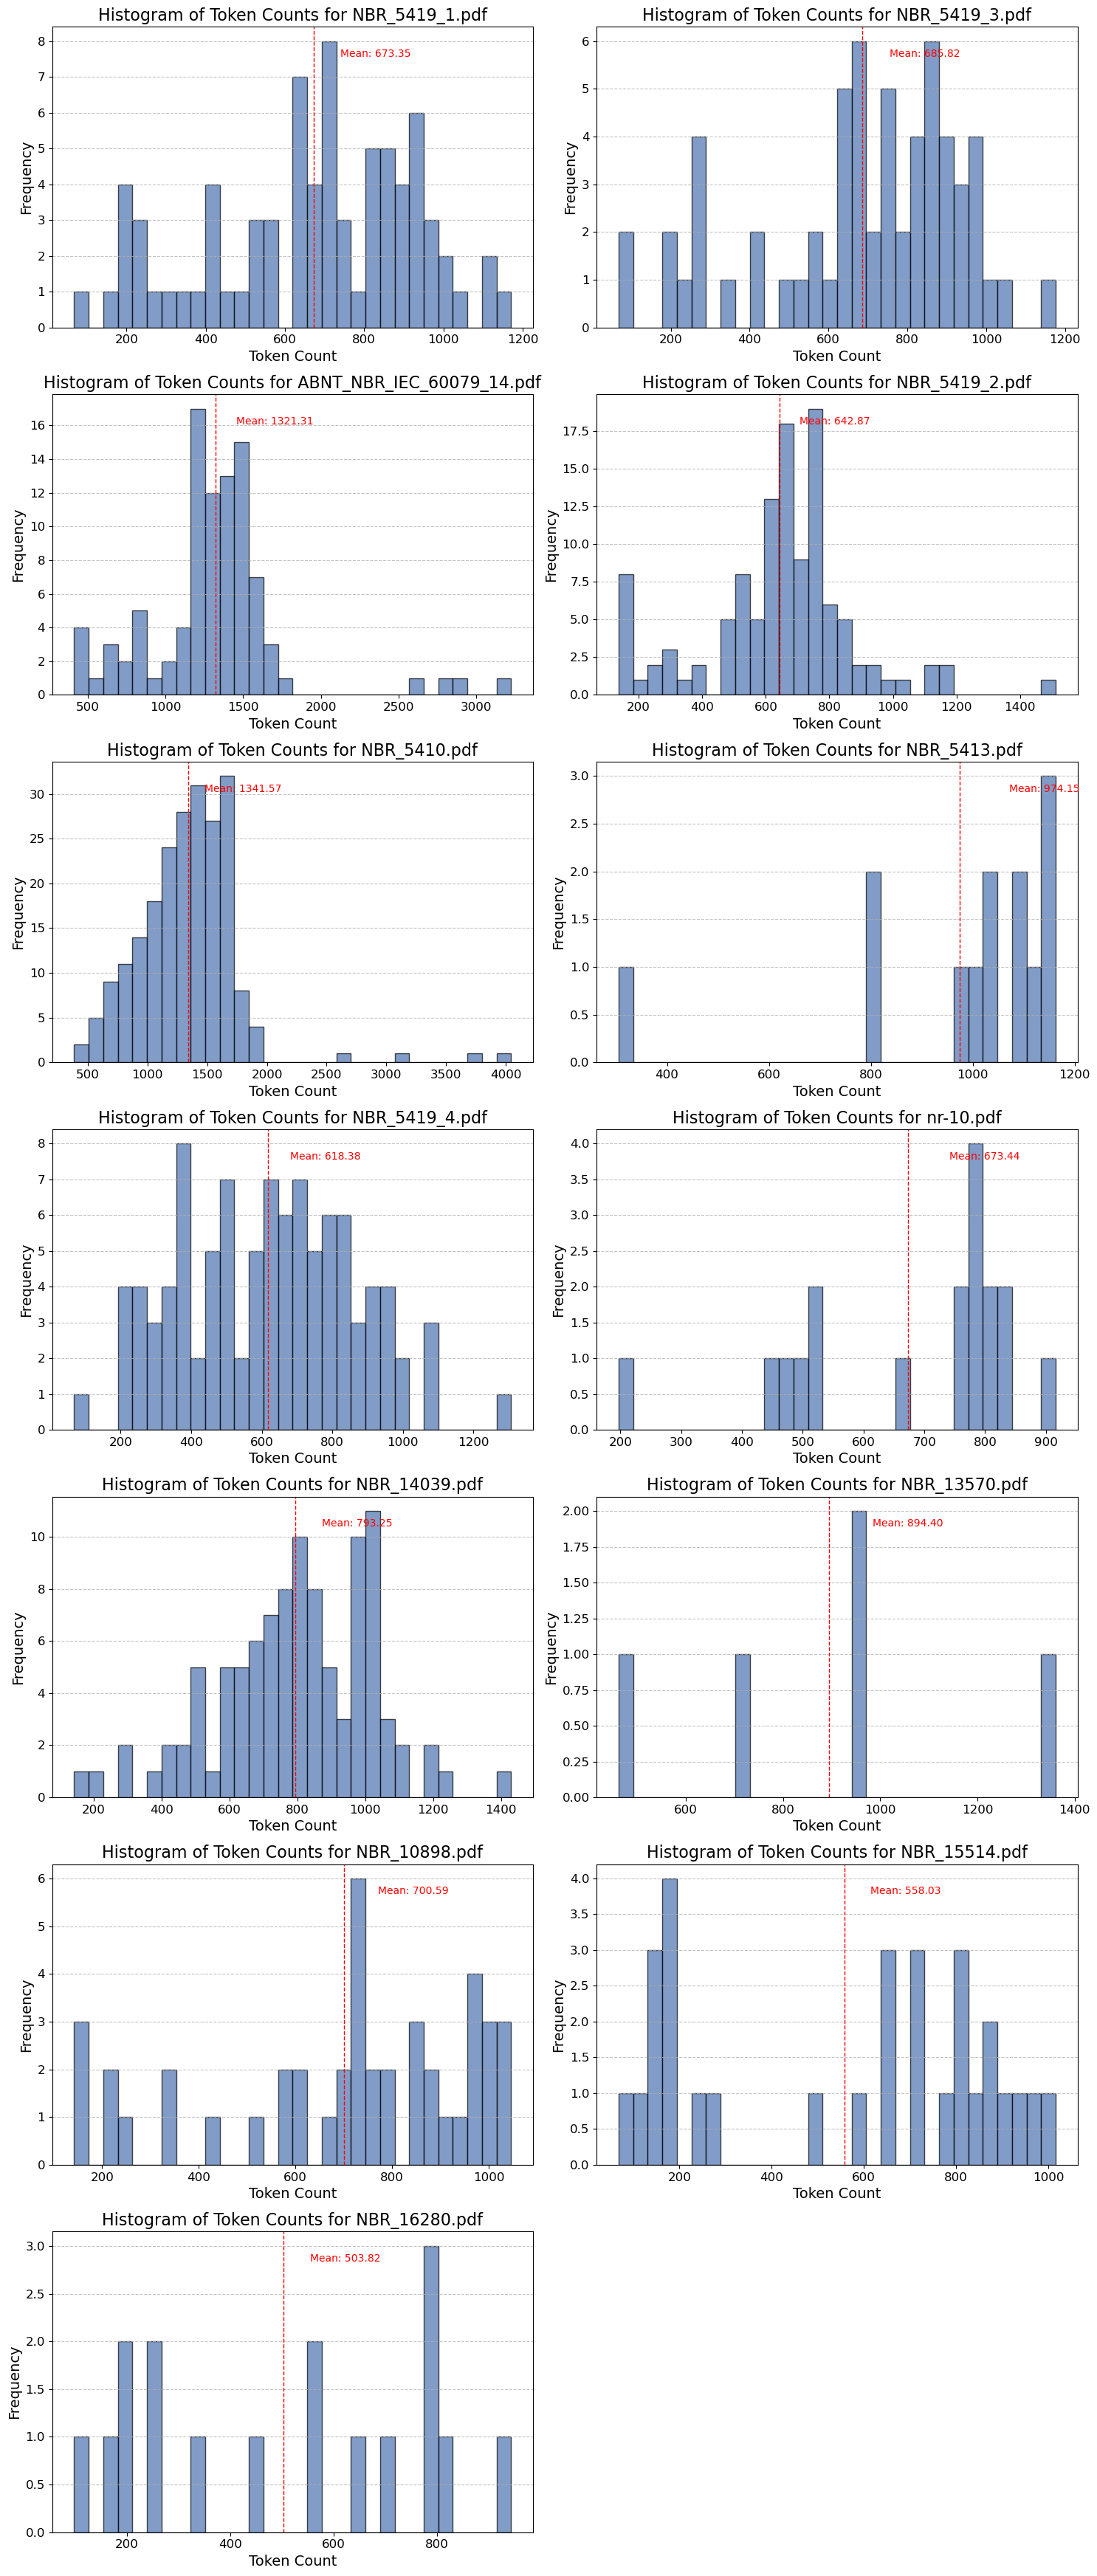

In [6]:
import tiktoken
import matplotlib.pyplot as plt

# Função para calcular o número de tokens
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """
    Returns the number of tokens in a text string.

    Parameters:
    - string (str): The input text string.
    - encoding_name (str): The name of the encoding to use for tokenization.

    Returns:
    - int: The number of tokens in the input text string.

    This function uses the tiktoken library to tokenize the input text string
    and count the number of tokens. The encoding name specifies the encoding
    to use for tokenization.
    """
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# Inicializar lista concatenada e lista para plotagem
docs = []
all_counts = []

# Determinar o número de PDFs para configurar a grade de subplots
num_pdfs = len(pdf_results)
rows = (num_pdfs + 1) // 2  # Ajuste para ter 2 colunas e o número adequado de linhas

fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))

# Garantir que axes seja um array 2D, mesmo se houver apenas uma linha
if rows == 1:
    axes = [axes]

# Concatenar conteúdo e plotar histogramas
for i, (filename, docs_in_file) in enumerate(pdf_results.items()):
    row = i // 2
    col = i % 2
    ax = axes[row][col]

    docs.extend(docs_in_file)
    docs_texts = [d.page_content for d in docs_in_file]

    # Calcular o número de tokens para cada documento
    counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]
    all_counts.extend(counts)

    # Plotar o histograma de contagem de tokens para cada PDF
    ax.hist(counts, bins=30, color="#4C72B0", edgecolor="black", alpha=0.7)
    ax.set_title(f"Histogram of Token Counts for {filename}", fontsize=16)
    ax.set_xlabel("Token Count", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.grid(axis="y", alpha=0.75, linestyle='--')

    # Melhorar a exibição das legendas
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Adicionar uma linha média
    mean_val = sum(counts) / len(counts)
    ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=1)
    ax.text(mean_val * 1.1, ax.get_ylim()[1] * 0.9, f'Mean: {mean_val:.2f}', color='red')

# Ajustar layout para não sobrepor títulos e etiquetas
plt.tight_layout()

# Remover subplots vazios
if num_pdfs % 2 != 0:
    fig.delaxes(axes[rows-1][1])

In [7]:
print(f"Number of total pages in all documents: {len(docs)}")

Number of total pages in all documents: 893


## Text processing

In [8]:
# Ordenar e reverter os documentos
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# Concatenar o conteúdo dos documentos
concatenated_content = "\n\n\n --- \n\n\n".join([doc.page_content for doc in d_reversed])

# Calcular o número total de tokens no conteúdo concatenado
total_tokens = num_tokens_from_string(concatenated_content, "cl100k_base")

# Exibir o número total de tokens
print(f"Num tokens in all context before cleaning the documents: {total_tokens}")

Num tokens in all context before cleaning the documents: 812990


### Cleaning the text 

In [9]:
import re

def cleaning_text(text_element: str)-> str:
    
    # Remover quebras de linha desnecessárias
    text = re.sub(r'\n+', ' ', text_element)
    
    # Remover números de página e sequências de dígitos isolados
    text = re.sub(r'\s\d+\s', ' ', text)
    
    # Remover espaços extras
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Corrigir espaços antes de pontuação
    text = re.sub(r'\s+([,.;:])', r'\1', text)
    
    return text

In [10]:
# Apply to texts
text = [doc.page_content for doc in d_reversed]

cleaned_texts = [cleaning_text(t) for t in text]

# Concatenar o conteúdo dos documentos
concatenated_cleaned_content  = "\n\n\n --- \n\n\n".join([i for i in cleaned_texts])

# Calcular o número total de tokens no conteúdo concatenado
total_tokens = num_tokens_from_string(concatenated_cleaned_content , "cl100k_base")

# Exibir o número total de tokens
print(f"Num tokens in all context after cleaning the documents: {total_tokens}")

Num tokens in all context after cleaning the documents: 643681


In [11]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)

texts_split = text_splitter.split_text(concatenated_cleaned_content)
print(f"Number of text splits generated:{len(texts_split)}")

Number of text splits generated:537


In [12]:
print(f"Number of text splits generated: {len(texts_split)}")

Number of text splits generated: 537


In [13]:
num_tokens_from_string(texts_split[0], "cl100k_base")

1453

### Embedding text splits

In [15]:
import time

# Função para calcular os embeddings com tempo de espera para evitar rate limit
def generate_embeddings(texts, embd, sleep_time=1):
    """
    Generates embeddings for a list of texts using the provided embedding model.
    
    Returns:
        list: A list of generated embeddings, corresponding to the input texts.
    """
    count = 0
    embeddings = []
    for txt in texts:
        try:
            embedding = embd.embed_query(txt)
            embeddings.append(embedding)
            count+=1
            
        except Exception as e:
            print(f"Error processing {txt[:50]}: {e}")
        
        # Rate-limit processing with sleep 
        if count %100 == 0:
            time.sleep(sleep_time) 
        
    return embeddings

# Gerar os embeddings com tempo de espera de 1 segundo entre as requisições
global_embeddings = generate_embeddings(texts_split, embd, sleep_time=1)

# Exibir o tamanho do vetor para o primeiro chunk
print(f"Size of the vector for the chunk 0 : {len(global_embeddings[0])}")

Size of the vector for the chunk 0 : 3072


In [16]:
print(f"Size of the vector for the chunk 2 : {len(global_embeddings[2])}")

Size of the vector for the chunk 2 : 3072


In [19]:
print(f'Len of the list of the list of texts chunks: {len(texts_split)}')
print(f'Len of the list of vectors embbeded: {len(global_embeddings)}')

Len of the list of the list of texts chunks: 537
Len of the list of vectors embbeded: 537


## Implementation of the RAPTOR for Indexing- Recursive Abstractive Processing for Tree-Organized Retrieval

### RAPTOR ALGORITHM

In [20]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 222  # Fixed seed for reproducibility

### --- Code from citations  --- ###

def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters

In [21]:
# from google.api_core.exceptions import InvalidArgument

def chunk_list(lst, chunk_size):
    """Divide uma lista em partes menores de um tamanho específico."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

def embed(texts: List[str], batch_size: int = 100) -> np.ndarray:
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.
    - batch_size: int, maximum number of texts to process in a single batch.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    all_embeddings = []
    for batch in chunk_list(texts, batch_size):
        try:
            batch_embeddings = embd.embed_documents(batch)
            all_embeddings.extend(batch_embeddings)
        except Exception as e:
            raise Exception(f"Error embedding content: {e}")
    return np.array(all_embeddings)


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Este é um trecho de um conjunto de documentos de normas regulamentadoras brasileiras (NBR's).

    As NBRs (Normas Regulamentadoras Brasileiras) definem padrões, regras e critérios que dizem respeito à aspectos da sociedade brasileira, incluindo práticas de engenharia e arquitetura\
    segurança e saúde no trabalho, qualidade de produtos e serviços, proteção ambiental, padronização de terminologia, desempenho de edificações, rotulagem de produtos, certificação de produtos e serviços.
    

    Faça um resumo detalhado da documentação fornecida.

    Documentação:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

### Build Tree structure

In [23]:
results = recursive_embed_cluster_summarize(texts_split, level=1, n_levels=3)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


--Generated 102 clusters--
--Generated 16 clusters--
--Generated 4 clusters--


### Visualizing the clusters in the tree

#### 1st level

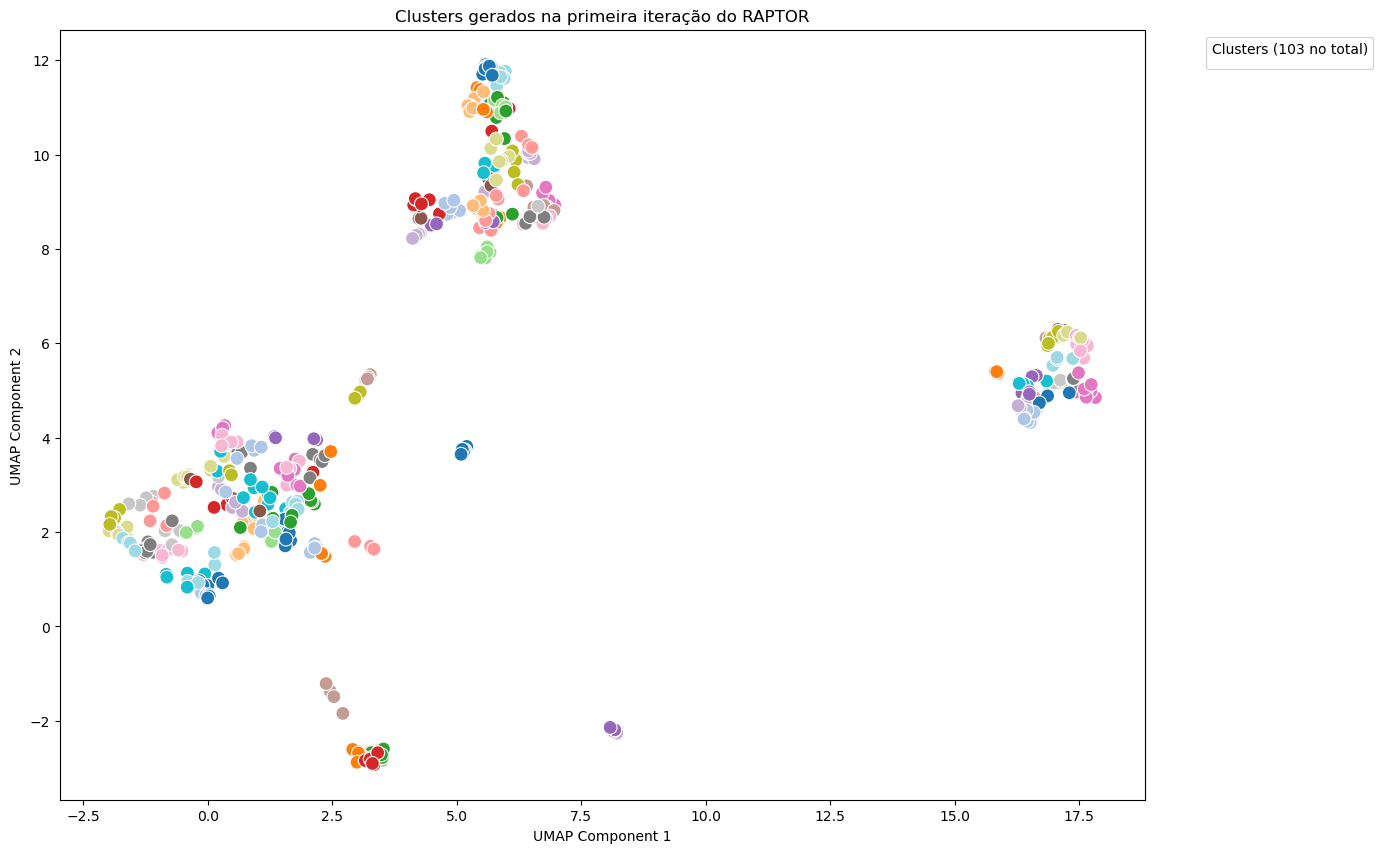

In [133]:
import warnings
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters_umap(df_clusters: pd.DataFrame, title: str, n_neighbors: int = 15, min_dist: float = 0.1):
    """
    Plota os clusters usando UMAP para redução de dimensionalidade.

    Parameters:
    - df_clusters: DataFrame contendo as colunas 'embd' (embeddings) e 'cluster' (labels de clusters).
    - title: Título do gráfico.
    - n_neighbors: Número de vizinhos próximos a considerar para UMAP.
    - min_dist: Distância mínima para UMAP.
    """
    # Extrair embeddings e labels
    embeddings = np.vstack(df_clusters['embd'].values)
    labels = df_clusters['cluster'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x).values
    
    # Reduzir dimensionalidade para 2D usando UMAP, desativando avisos temporariamente
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=RANDOM_SEED)
        embeddings_2d = umap_model.fit_transform(embeddings)
    
    # Criar DataFrame para visualização
    df_plot = pd.DataFrame(data={'x': embeddings_2d[:, 0], 'y': embeddings_2d[:, 1], 'cluster': labels})
    
    # Converter clusters para string para evitar problemas de comparação
    df_plot['cluster'] = df_plot['cluster'].astype(str)
    
    # Obter o número de clusters únicos
    num_clusters = df_plot['cluster'].nunique()
    
    # Plotar os clusters
    plt.figure(figsize=(14, 10))
    scatter = sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='tab20', s=100, legend=False)
    plt.title(title)
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')

    # Ajustar a legenda
    handles, labels = scatter.get_legend_handles_labels()
    plt.legend(handles=handles[:20], labels=labels[:20], title=f'Clusters ({num_clusters} no total)', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

# Assumindo que `results` é o dicionário retornado pela função `recursive_embed_cluster_summarize`
# e que queremos plotar os clusters da primeira iteração
df_clusters_level_1, _ = results[1]
plot_clusters_umap(df_clusters_level_1, "Clusters gerados na primeira iteração do RAPTOR")


#### 2nd level

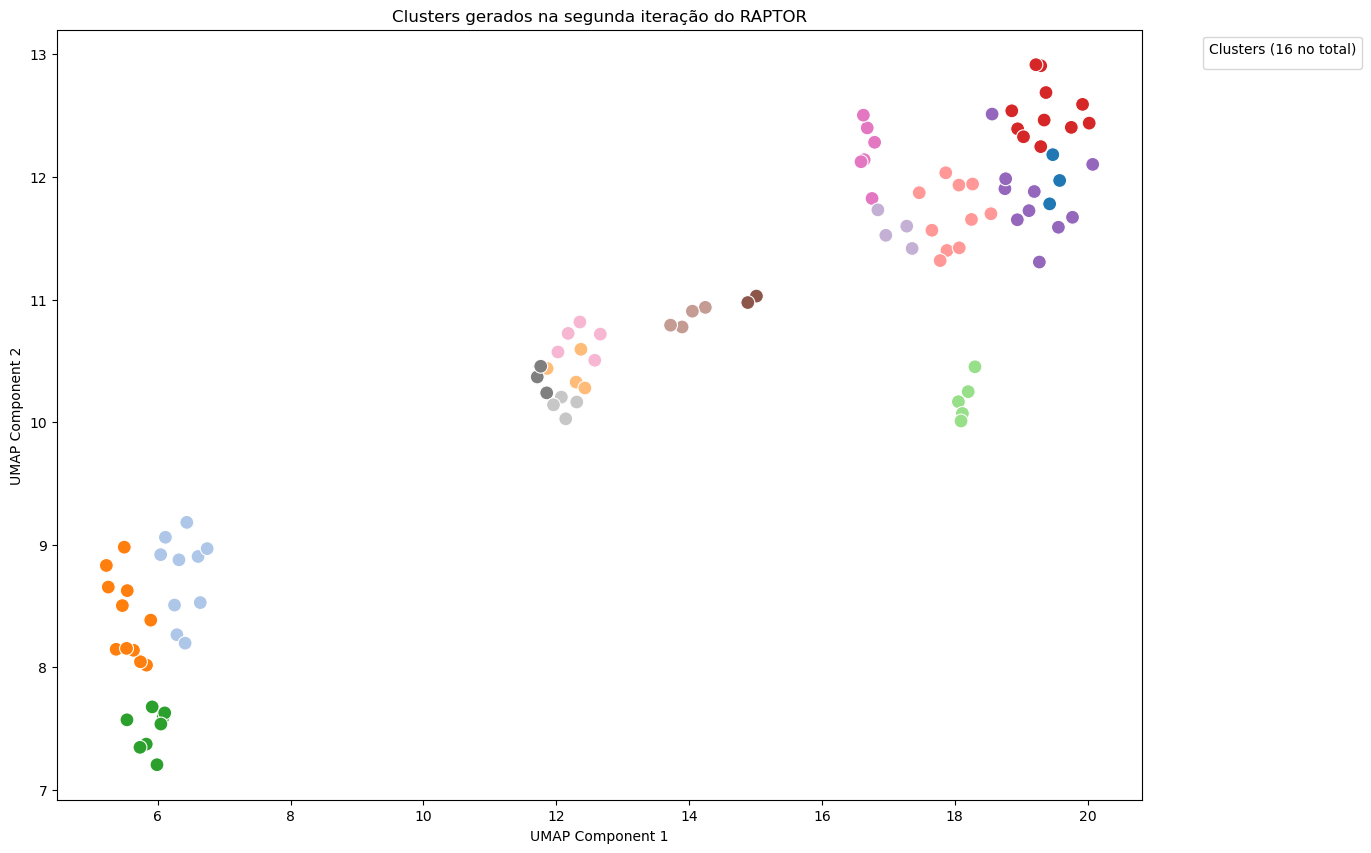

In [135]:
df_clusters_level_2, _ = results[2]
plot_clusters_umap(df_clusters_level_2, "Clusters gerados na segunda iteração do RAPTOR")

#### 3rd level

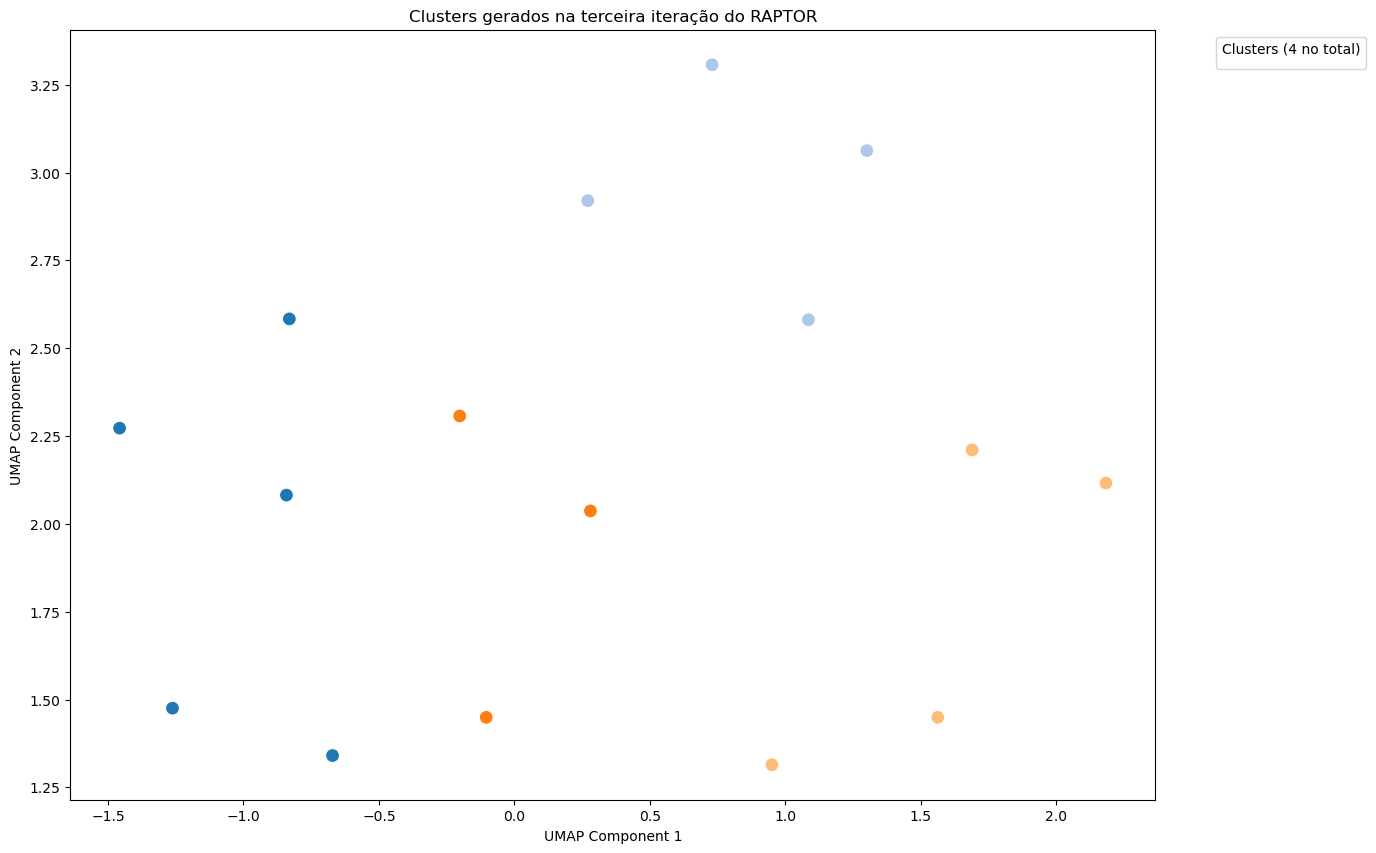

In [137]:
df_clusters_level_3, _ = results[3]
plot_clusters_umap(df_clusters_level_3, "Clusters gerados na terceira iteração do RAPTOR")

### Collapsed Tree Retrieval
* Isso envolve o achatamento da estrutura da árvore em uma única camada e, em seguida, a aplicação de uma pesquisa de k vizinhos mais próximos (kNN) em todos os nós simultaneamente.
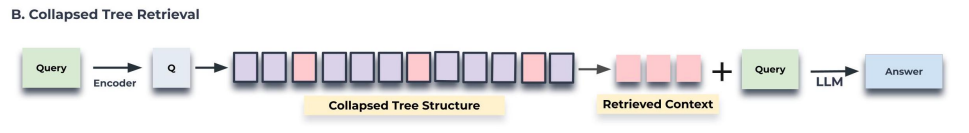

In [128]:
# Initialize all_texts with raw_texts
all_texts = texts_split.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

### Add to vectorstore

In [27]:
len(all_texts)

659

#### Add the documents to the vectorial database

In [29]:
from langchain_community.vectorstores import Chroma

# Diretório onde o vectorstore será persistido
persist_directory = "vectorstore_db_openai_v2"

# Inicializando o vectorstore
vectorstore = Chroma(
    collection_name="RAPTOR_vectorstore",
    embedding_function=embd,
    persist_directory=persist_directory
)

# imprimir banco de dados inicializado
import sqlite3
import pandas as pd

# Conexão ao banco de dados SQLite
conn = sqlite3.connect('vectorstore_db_openai_v2/chroma.sqlite3')

tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
# Consulta SQL
query = "SELECT * FROM embedding_fulltext_search"

# Executa a consulta e retorna um DataFrame
df = pd.read_sql_query(query, conn)

print(tables)
# Exibe o DataFrame
print(df,"\n\n")

conn.close()

                                 name
0                          migrations
1                    embeddings_queue
2                 collection_metadata
3                            segments
4                    segment_metadata
5                             tenants
6                           databases
7                         collections
8                          embeddings
9                  embedding_metadata
10                         max_seq_id
11          embedding_fulltext_search
12     embedding_fulltext_search_data
13      embedding_fulltext_search_idx
14  embedding_fulltext_search_content
15  embedding_fulltext_search_docsize
16   embedding_fulltext_search_config
Empty DataFrame
Columns: [string_value]
Index: [] 




In [30]:
vectorstore.add_texts(all_texts)

['7d520439-bcf8-4472-aa9b-8f85cdff3ece',
 'ccc6036e-e958-4c67-88a7-541fb8f836c0',
 '6861ba6d-6ff2-4b69-bd6f-57fd070d693f',
 'e9354925-a929-4293-8d1b-d419414e8496',
 '3b79a0de-2235-4e8f-8a34-0517fcb4cc34',
 '88e8daf3-3079-4f33-b8aa-dbaa48472830',
 '9fd0cf7d-c29e-4159-9c0c-64865db15dbf',
 'e9655be5-4d7e-4319-ac5f-637a2d795977',
 '6b5efe54-81f5-41c1-8f88-8ffc9985ad32',
 '5cb9abd5-9942-4766-9212-7beecd9bb05b',
 '65cd06f2-e276-4442-983f-d915f1b9dc0a',
 'cc3ba618-dc5b-4d0f-af4d-e3869f03bfc7',
 '505faac5-136b-43be-b6dc-c3da5c2538a4',
 '6e557a2d-421d-482a-83df-4dad0f06220e',
 'f13326ff-99fa-4cc0-81fa-39d6cb6d96fb',
 '6b824846-3283-45c6-ac1e-1e42e9bd29c4',
 '33675f1a-8d0a-444d-b178-8b2433b62d36',
 '1f2253a3-0ad9-413b-91ee-3a6cda363063',
 'aa19cd0f-afbe-4445-9d02-1a2ec763c4ea',
 '238f4690-b467-47e4-901e-8f9209958049',
 'dbcd7149-5431-46d4-a600-2f6cdbf804b4',
 '2bb4352b-b8de-40da-8d00-5a847bf92d42',
 '40861810-d1fc-4d29-bf6c-e5742e4eddfb',
 'bfc7f1e5-0349-4712-bedc-a9bc9478dd22',
 '95f0dc1a-9ad8-

In [33]:
# Conexão ao banco de dados SQLite
conn = sqlite3.connect('vectorstore_db_openai/chroma.sqlite3')

# Executa a consulta e retorna um DataFrame
df = pd.read_sql_query("SELECT * FROM collections", conn)

conn.close()


# Exibe o DataFrame
print(df,"\n\n")

                                     id                name  dimension  \
0  d7291a4b-0908-4d79-89ab-a1d3b47a3bd3  RAPTOR_vectorstore       3072   

                            database_id  
0  00000000-0000-0000-0000-000000000000   




## Define the Retriever

In [34]:
#inicializate the vectostore from a persistent database
from langchain_community.vectorstores import Chroma

# Diretório onde o vectorstore será persistido
persist_directory = "vectorstore_db_openai_v2"

# Inicializando o vectorstore
vectorstore = Chroma(
    collection_name="RAPTOR_vectorstore",
    embedding_function=embd,
    persist_directory=persist_directory
)

In [35]:
#apply a k-nearest neighbors (kNN) search across all nodes simultaneously.
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

## RAG Pipeline

### RAG Pipeline without context visualization

In [36]:
import textwrap
from IPython.display import Markdown

def to_markdown(text):
    text = text.replace('•', '*')
    text = textwrap.dedent(text).strip()

    return Markdown(text)

In [37]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = """
Responda a pergunta baseado no seguinte contexto:
{context}

Responda a seguinte pergunta:
Pergunta: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)   

In [38]:
question = "Quais são os principais requisitos estabelecidos pela NBR 5410 para a proteção contra choques elétricos em instalações elétricas de baixa tensão?"
response = rag_chain.invoke(question)
to_markdown(response)

A NBR 5410 estabelece os seguintes requisitos principais para proteção contra choques elétricos em instalações de baixa tensão:

**1. Proteção contra contatos diretos:**

* **Inacessibilidade a partes vivas:** As partes vivas da instalação devem ser inacessíveis a pessoas e animais, seja por meio de **isolação** adequada ou pelo uso de **barreiras/invólucros** (com grau de proteção IPXXB ou IP2X).
* **Isolação:** A isolação das partes vivas deve ser completa e removível apenas com destruição. A isolação aplicada na instalação deve possuir resistência mecânica, química, elétrica e térmica adequadas.
* **Barreiras/Invólucros:** As barreiras ou invólucros devem impedir qualquer contato acidental com as partes vivas, inclusive durante a substituição de componentes como lâmpadas e fusíveis.

**2. Proteção contra contatos indiretos:**

* **Seccionamento automático da alimentação:** Em caso de falha que possa resultar na energização de massas, a alimentação do circuito deve ser automaticamente seccionada em tempo hábil para evitar choques.
* **Equipotencialização:** As massas da instalação devem ser conectadas a condutores de proteção (terra) para garantir a equipotencialidade e evitar o aparecimento de tensões de contato perigosas.

**3. Medidas de proteção adicionais:**

* **Isolação dupla ou reforçada:** Equipamentos com invólucros isolantes devem atender a requisitos específicos de grau de proteção, materiais, conexões e compatibilidade com o funcionamento.
* **SELV e PELV:** Sistemas de extrabaixa tensão com separação elétrica (SELV) ou proteção equivalente (PELV) podem ser utilizados para prevenir choques em caso de falha, limitando a tensão em áreas acessíveis.

**4. Aplicação das medidas de proteção:**

* As medidas de proteção devem ser aplicadas de forma integrada, considerando as características específicas de cada instalação.
* A equipotencialização e o seccionamento automático da alimentação são considerados medidas gerais de proteção.
* Outras medidas, como a proteção adicional, podem ser necessárias em situações específicas ou para complementar a proteção.

Em resumo, a NBR 5410 exige a proteção contra contatos diretos e indiretos como requisitos fundamentais para a segurança em instalações elétricas de baixa tensão. A norma define medidas de proteção específicas, como o uso de isolação, barreiras, seccionamento automático da alimentação e equipotencialização, que devem ser aplicadas de forma integrada e considerando as particularidades de cada instalação.

In [ ]:
# Question
response = rag_chain.invoke("O que diz a norma NBR 5410 no geral?")
to_markdown(response)

In [ ]:
# Question
question = "qual a profundidade mínima que deve ser enterrado o condutor de uma malha de aterramento? Quais normas falam sobre esse assunto?"
response = rag_chain.invoke(question)
to_markdown(response)

In [39]:
# Question
question = "Quais são as exigências da Norma Regulamentadora NR 10 para as instalações elétricas em áreas classificadas?"
response = rag_chain.invoke(question)
to_markdown(response)

A Norma Regulamentadora NR 10 define diversas exigências para instalações elétricas em áreas classificadas, com foco na prevenção de incêndios e explosões. Abaixo estão algumas das principais exigências, com base nos trechos fornecidos:

**Instalações Elétricas:**

* **Dispositivos de Proteção:** Utilização obrigatória de dispositivos de proteção como alarme e seccionamento automático para prevenir situações anormais de operação, como sobretensões, sobrecorrentes, falhas de isolamento e aquecimentos (10.9.4).
* **Proteção contra Incêndio e Explosão:** As áreas com instalações elétricas devem possuir proteção contra incêndio e explosão conforme a NR - Proteção Contra Incêndios (10.9.1).
* **Materiais e Equipamentos:** Utilização de materiais, peças, dispositivos, equipamentos e sistemas adequados para atmosferas potencialmente explosivas, com certificação conforme o Sistema Brasileiro de Certificação (10.9.2).
* **Eletricidade Estática:** Processos e equipamentos com potencial de gerar ou acumular eletricidade estática devem dispor de proteção específica e dispositivos de descarga elétrica (10.9.3).

**Trabalho em Áreas Classificadas:**

* **Permissão para Trabalho:** Os serviços em instalações elétricas nessas áreas exigem permissão formalizada para trabalho, com liberação conforme o item 10.5 ou supressão do agente de risco (10.9.5).
* **Treinamento Específico:** Trabalhadores em áreas classificadas necessitam de treinamento específico sobre os riscos da área e as medidas de segurança (10.8.8.4).

**Outras Considerações:**

* As normas ABNT NBR IEC 60079-14:2009 e IEC 60364-4-41 são referenciadas para especificações adicionais sobre separação elétrica, potencial de equalização e outros requisitos técnicos.
* A NR 10 também aborda a importância da sinalização de segurança (10.10) e da elaboração de procedimentos de trabalho detalhados (10.11) para garantir a segurança dos trabalhadores.

**Observação:** Esta resposta fornece um resumo das exigências. É crucial consultar a íntegra da NR 10 e outras normas relacionadas para uma compreensão completa e aplicação correta das medidas de segurança em áreas classificadas.

In [ ]:
# Question
question = "Quais são as exigências da Norma Regulamentadora NR 10 para as instalações elétricas em áreas classificadas?"
response = rag_chain.invoke(question)
to_markdown(response)

### RAG Pipeline with context visualization

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableMap


template = """
Responda a pergunta baseado no seguinte contexto:
{context}

Responda a seguinte pergunta.:
Pergunta: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Função para imprimir o contexto
def print_context(context):
    print("Contexto fornecido:", context)
    return context

rag_chain_with_context = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | RunnableMap({"context": print_context, "question": RunnablePassthrough()})
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
# Question
question = "Quais são as exigências da Norma Regulamentadora NR 10 para as instalações elétricas em áreas classificadas?"
response = rag_chain_with_context.invoke(question)
to_markdown(response)

In [ ]:
# Question
question = 'O que diz a norma NBR 5410 no geral?'
response = rag_chain_with_context.invoke(question)
to_markdown(response)

### Testing with MultiQuery Retriver

In [ ]:
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_core.runnables import RunnableMap
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=vectorstore.as_retriever(search_kwargs={"k": 3}), llm=model
)

template = """
Responda a pergunta baseado no seguinte contexto:
{context}

Responda a seguinte pergunta:
Pergunta: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# Função para imprimir o contexto
def print_context(context):
    print(f"Contexto fornecido:{context} \n")
    print(f"Tamanho do contexto: {len(context)} \n")
    return context

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain_with_context = (
    {"context": multi_query_retriever | format_docs, "question": RunnablePassthrough()}
    | RunnableMap({"context": print_context, "question": RunnablePassthrough()})
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
question = "Quais são os principais requisitos estabelecidos pela NBR 5410 para a proteção contra choques elétricos em instalações elétricas de baixa tensão?"
response = rag_chain_with_context.invoke(question)
to_markdown(response)

In [ ]:
# Question
question = "Quais são as exigências da Norma Regulamentadora NR 10 para as instalações elétricas em áreas classificadas?"
response = rag_chain_with_context.invoke(question)
to_markdown(response)

In [ ]:
# Question
question = "O que diz a NR 10 de maneira geral?"
response = rag_chain_with_context.invoke(question)
to_markdown(response)

In [ ]:
# Question
question = "Quais são as exigências da Norma Regulamentadora NR 10 para as instalações elétricas em áreas classificadas?"
response = rag_chain.invoke(question)
to_markdown(response)

In [ ]:
# Question
question = "qual a profundidade mínima que deve ser enterrado o condutor de uma malha de aterramento? Quais normas falam sobre esse assunto?"
response = rag_chain.invoke(question)
to_markdown(response)

## Black Box End-to-End Evaluation

### Questions database

In [40]:
questions = [
    # ABNT NBR IEC 60079
    "Quais são os principais requisitos de segurança para a instalação de equipamentos elétricos em atmosferas explosivas conforme a ABNT NBR IEC 60079?",
    "Como a ABNT NBR IEC 60079 classifica as zonas de risco em áreas com atmosferas explosivas e quais são os critérios utilizados para essa classificação?",
    "Quais são os métodos de proteção permitidos pela ABNT NBR IEC 60079 para garantir a segurança de instalações elétricas em atmosferas explosivas?",
    "Como a manutenção e inspeção de equipamentos elétricos em atmosferas explosivas devem ser conduzidas de acordo com a ABNT NBR IEC 60079?",
    "Quais são as especificações técnicas para a seleção de equipamentos elétricos adequados para uso em atmosferas explosivas conforme a ABNT NBR IEC 60079?",

    # NBR 5410
    "Quais são os requisitos essenciais para a proteção contra choques elétricos em instalações elétricas de baixa tensão segundo a NBR 5410?",
    "Como a NBR 5410 aborda a questão da equipotencialização e aterramento em instalações elétricas?",
    "Quais são as diretrizes da NBR 5410 para a instalação de dispositivos de proteção contra sobrecorrente?",
    "De que maneira a NBR 5410 define as zonas de proteção e os limites de influência eletromagnética em instalações elétricas?",
    "Quais são os critérios da NBR 5410 para a instalação de sistemas de iluminação de emergência em edificações residenciais e comerciais?",

    # NBR 5413
    "Quais são os critérios estabelecidos pela NBR 5413 para o nível de iluminância em diferentes ambientes de trabalho?",
    "Como a NBR 5413 define a uniformidade da iluminação e quais são os métodos para garantir essa uniformidade?",
    "Quais são as recomendações da NBR 5413 para a prevenção de ofuscamento em ambientes de trabalho?",
    "De que maneira a NBR 5413 aborda a questão da reprodução de cores em sistemas de iluminação?",
    "Quais são as diretrizes da NBR 5413 para a medição e verificação dos níveis de iluminância em ambientes de trabalho?",

    # NBR 5419 (Incluindo todas as 4 normas)
    "Quais são os princípios gerais estabelecidos pela NBR 5419-1 para a proteção de estruturas contra descargas atmosféricas?",
    "Como a NBR 5419-2 aborda a avaliação de risco associada a descargas atmosféricas e quais são os fatores considerados?",
    "Quais são os requisitos para o projeto e a instalação de sistemas de proteção contra descargas atmosféricas segundo a NBR 5419-3?",
    "De que forma a NBR 5419-4 trata a proteção de estruturas contra os efeitos secundários das descargas atmosféricas?",
    "Quais são as orientações da NBR 5419 para a manutenção e inspeção de sistemas de proteção contra descargas atmosféricas?",

    # NBR 10898
    "Quais são os requisitos estabelecidos pela NBR 10898 para os sistemas de iluminação de emergência em edifícios?",
    "Como a NBR 10898 define a autonomia e a intensidade mínima para sistemas de iluminação de emergência?",
    "Quais são as especificações para a manutenção e teste regular dos sistemas de iluminação de emergência conforme a NBR 10898?",
    "Quais são os critérios para a localização e instalação de luminárias de emergência segundo a NBR 10898?",
    "Como a NBR 10898 aborda a questão da sinalização luminosa em casos de emergência?",

    # NBR 13570
    "Quais são os requisitos para a instalação de equipamentos elétricos em atmosferas explosivas conforme a NBR 13570?",
    "Como a NBR 13570 classifica as áreas de risco em atmosferas explosivas e quais são as categorias de zonas?",
    "Quais são os métodos de proteção recomendados pela NBR 13570 para garantir a segurança em atmosferas explosivas?",
    "De que forma a NBR 13570 aborda a inspeção e a manutenção de equipamentos elétricos em atmosferas explosivas?",
    "Quais são as orientações para a seleção de equipamentos elétricos adequados para uso em atmosferas explosivas segundo a NBR 13570?",

    # NBR 14039
    "Quais são os principais requisitos da NBR 14039 para instalações elétricas de média tensão?",
    "Como a NBR 14039 define os procedimentos de instalação e manutenção para garantir a segurança em instalações de média tensão?",
    "Quais são as diretrizes da NBR 14039 para a seleção de materiais e componentes em sistemas de média tensão?",
    "Quais são os requisitos de proteção e seccionamento estabelecidos pela NBR 14039 para instalações elétricas de média tensão?",
    "De que maneira a NBR 14039 trata a segurança operacional e de manutenção em instalações de média tensão?",

    # NBR 15514
    "Quais são os critérios de desempenho estabelecidos pela NBR 15514 para sistemas de cabeamento estruturado?",
    "Como a NBR 15514 categoriza os cabos e conectores utilizados em sistemas de cabeamento estruturado?",
    "Quais são os requisitos de instalação e teste para garantir a confiabilidade dos sistemas de cabeamento estruturado segundo a NBR 15514?",
    "Quais são as especificações para a transmissão de dados em sistemas de cabeamento estruturado conforme a NBR 15514?",
    "De que forma a NBR 15514 aborda a compatibilidade eletromagnética em sistemas de cabeamento estruturado?",

    # NBR 16280
    "Quais são as exigências da NBR 16280 para a aprovação prévia de projetos de reforma em edificações?",
    "Como a NBR 16280 define as responsabilidades dos profissionais envolvidos em reformas de edificações?",
    "Quais são os requisitos de segurança estabelecidos pela NBR 16280 para reformas em edificações?",
    "Quais são as diretrizes da NBR 16280 para a conformidade com as normas técnicas aplicáveis durante reformas?",
    "De que maneira a NBR 16280 trata a preservação da integridade estrutural e a segurança dos ocupantes durante reformas?",

    # NR 10
    "Quais são os principais requisitos de segurança para instalações e serviços em eletricidade conforme a NR 10?",
    "Como a NR 10 aborda a capacitação e a formação dos trabalhadores que atuam com eletricidade?",
    "Quais são as medidas de proteção coletiva e individual estabelecidas pela NR 10 para trabalhos com eletricidade?",
    "De que forma a NR 10 trata a manutenção e a inspeção periódica das instalações elétricas?",
    "Quais são os procedimentos de emergência e primeiros socorros definidos pela NR 10 em casos de acidentes elétricos?"
]



### Pipeline to generate the answer by LLM

In [41]:
from datasets import Dataset

answers = []
contexts = []

# Inference
for i, query in enumerate(questions):
    logging.info(f"Processing query {i+1}/{len(questions)}: {query}")
    
    try:
        answer = rag_chain.invoke(query)
        answers.append(answer)
        logging.info(f"Retrieved answer for query {i+1}: {answer}")

        context = [docs.page_content for docs in retriever.get_relevant_documents(query)]
        contexts.append(context)
        logging.info(f"Retrieved context for query {i+1}, context size: {len(context)} items")
        
    except Exception as e:
        logging.error(f"Error processing query {i+1}: {e}")
        answers.append(None)
        contexts.append([])
        
# To dict
data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

/opt/homebrew/anaconda3/envs/tcc/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


In [43]:
from ragas.metrics import ContextRelevancy
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
)

context_relevancy = ContextRelevancy()

eval_result = evaluate(
    dataset = dataset,
    llm = model,
    embeddings= embd,
    metrics=[
        faithfulness,
        answer_relevancy
    ],
)

df = eval_result.to_pandas()

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

In [44]:
df.head()

,question,answer,contexts,faithfulness,answer_relevancy
0,Quais são os principais requisitos de seguranç...,A ABNT NBR IEC 60079-14 descreve diversos requ...,[ABNT NBR IEC 60079-14:2009 ABNT NBR IEC 60079...,1.000000,0.892803
1,Como a ABNT NBR IEC 60079 classifica as zonas ...,A ABNT NBR IEC 60079-14:2009 classifica as zon...,[ABNT NBR IEC 60079-14:2009 ABNT NBR IEC 60079...,1.000000,0.900081
2,Quais são os métodos de proteção permitidos pe...,A ABNT NBR IEC 60079-14 não lista explicitamen...,[ABNT NBR IEC 60079-14:2009 ABNT NBR IEC 60079...,0.875000,0.783336
3,Como a manutenção e inspeção de equipamentos e...,A ABNT NBR IEC 60079-14 não detalha os procedi...,[ABNT NBR IEC 60079-14:2009 ABNT NBR IEC 60079...,0.923077,0.779851
4,Quais são as especificações técnicas para a se...,Para selecionar equipamentos elétricos adequad...,[ABNT NBR IEC 60079-14:2009 ABNT NBR IEC 60079...,1.000000,0.857804


In [45]:
df['answer_relevancy'].describe()

count    50.000000
mean      0.754221
std       0.291572
min       0.000000
25%       0.775670
50%       0.863989
75%       0.917772
max       0.961653
Name: answer_relevancy, dtype: float64

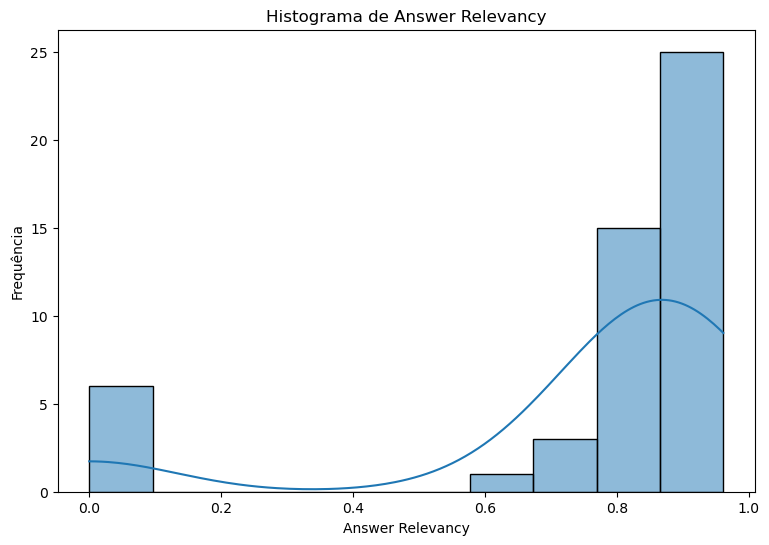

In [148]:
# Histograma
plt.figure(figsize=(9, 6))
sns.histplot(df['answer_relevancy'], bins=10, kde=True)
plt.title('Histograma de Answer Relevancy')
plt.xlabel('Answer Relevancy')
plt.ylabel('Frequência')
plt.show()

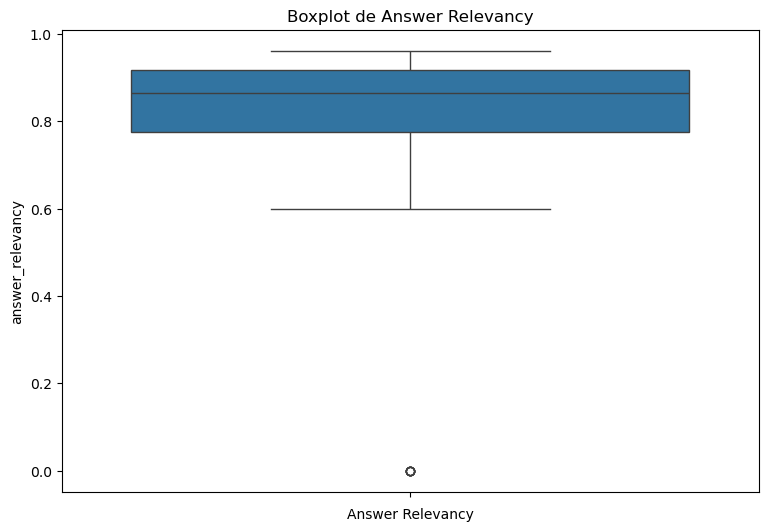

In [143]:
# Boxplot
plt.figure(figsize=(9, 6))
sns.boxplot(y=df['answer_relevancy'])
plt.title('Boxplot de Answer Relevancy')
plt.xlabel('Answer Relevancy')
plt.show()

In [46]:
df['faithfulness'].describe()

count    48.000000
mean      0.774970
std       0.271778
min       0.000000
25%       0.672917
50%       0.901613
75%       0.976025
max       1.000000
Name: faithfulness, dtype: float64

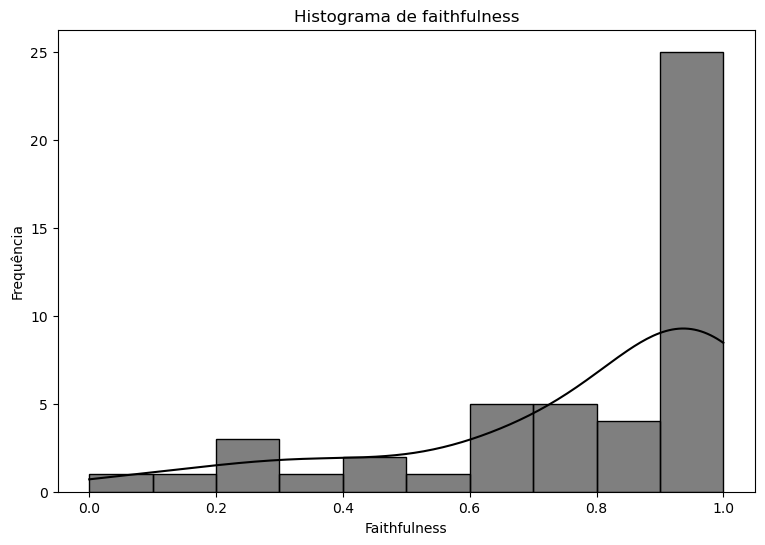

In [155]:
# Histograma
plt.figure(figsize=(9, 6))
sns.histplot(df['faithfulness'], bins=10, kde=True, color='black')
plt.title('Histograma de faithfulness')
plt.xlabel('Faithfulness')
plt.ylabel('Frequência')
plt.show()

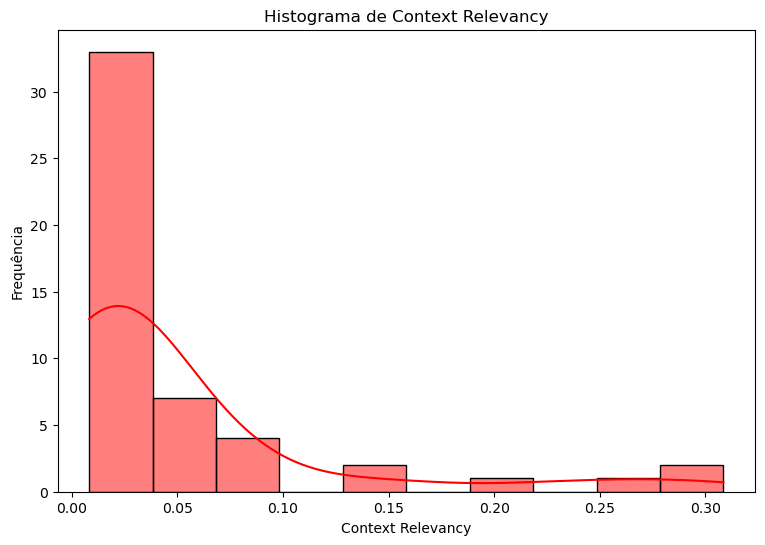

In [156]:
# Histograma
plt.figure(figsize=(9, 6))
sns.histplot(df['context_relevancy'], bins=10, kde=True, color='red')
plt.title('Histograma de Context Relevancy')
plt.xlabel('Context Relevancy')
plt.ylabel('Frequência')
plt.show()

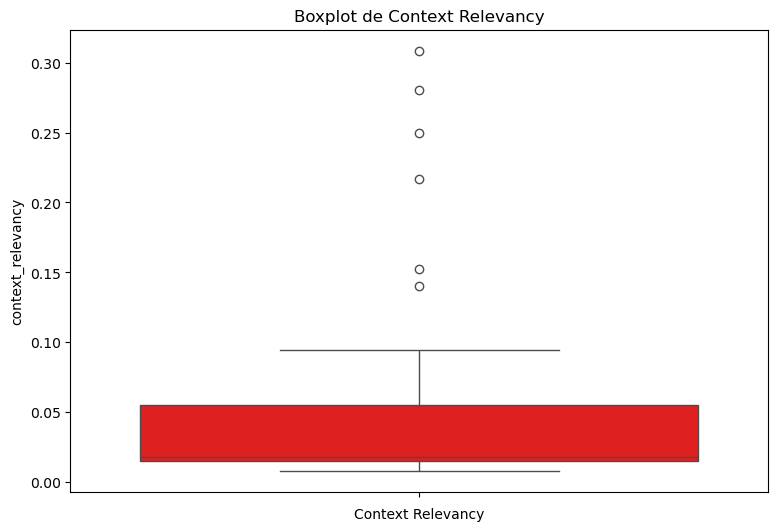

In [158]:
# Boxplot
plt.figure(figsize=(9, 6))
sns.boxplot(y=df['context_relevancy'], color= 'red')
plt.title('Boxplot de Context Relevancy')
plt.xlabel('Context Relevancy')
plt.show()

In [47]:
output_file = 'dataframe_evaluation.xlsx'

# Exportar o DataFrame para um arquivo Excel
df.to_excel(output_file, index=False)

print(f"DataFrame exportado para {output_file}")

DataFrame exportado para dataframe_evaluation.xlsx


### Context Relevancy Metric

In [159]:
df['context_relevancy'].describe()

count    50.000000
mean      0.050841
std       0.071267
min       0.008197
25%       0.014925
50%       0.017701
75%       0.055080
max       0.308511
Name: context_relevancy, dtype: float64

In [ ]:
import nest_asyncio
from ragas.metrics import ContextRelevancy
import asyncio

# Permitir o uso de asyncio.run em um loop de evento existente
nest_asyncio.apply()

# Instanciar a métrica de Context Relevancy
context_relevancy = ContextRelevancy(llm=model)

# Definir uma função assíncrona para calcular a métrica
async def calculate_context_relevancy(dataset):
    results = []
    for row in dataset:
        question = row['question']
        context = row['contexts']
        
        context_str = "\n".join(context)
        prompt = context_relevancy.context_relevancy_prompt.format(question=question, context="\n".join(context_str))
        
        # Gerando o resultado a partir do LLM
        result = context_relevancy.llm.generate(prompts=[str(prompt)], callbacks=None)
        
        # Verificando o conteúdo do resultado
        # print("Prompt enviado ao LLM:", prompt)
        # print("Resultado do LLM:", result.generations[0][0].text)
        
        # Calculando a pontuação de relevância do contexto
        score = context_relevancy._compute_score(result.generations[0][0].text, {"question": question, "contexts": context})
        results.append(score)
    return results

# Calcular a métrica de relevância do contexto para o dataset
results_context_relevancy = asyncio.run(calculate_context_relevancy(dataset))

# Adicionar os resultados ao DataFrame original
df['context_relevancy'] = results_context_relevancy

# Exibir os primeiros resultados
df.head()

In [97]:
import nest_asyncio
import pandas as pd
from datasets import Dataset
from ragas.metrics import ContextRelevancy
import asyncio

# Permitir o uso de asyncio.run em um loop de evento existente
nest_asyncio.apply()

# Converter o dicionário para um Dataset do Hugging Face
dataset = Dataset.from_dict(data)

# Instanciar a métrica de Context Relevancy
context_relevancy = ContextRelevancy(llm=model)

# Definir uma função assíncrona para calcular a métrica
async def calculate_context_relevancy(dataset):
    results = []
    for row in dataset:
        question = row['question']
        context = row['contexts']
        
        context_str = "\n".join(context)
        prompt = context_relevancy.context_relevancy_prompt.format(question=question, context=context_str)
        
        try:
            # Gerando o resultado a partir do LLM
            result = context_relevancy.llm.generate(prompts=[str(prompt)], callbacks=None)
            
            # Verifique o conteúdo do resultado
            print("Prompt enviado ao LLM:", prompt)
            print("Resultado do LLM:", result.generations[0][0].text)
            
            # Calculando a pontuação de relevância do contexto
            score = context_relevancy._compute_score(result.generations[0][0].text, {"question": question, "contexts": context})
            results.append(score)
        except Exception as e:
            print(f"Erro ao processar a pergunta '{question}': {str(e)}")
            results.append(None)
    return results

# Calcular a métrica de relevância do contexto para o dataset
results_context_relevancy = asyncio.run(calculate_context_relevancy(dataset))


df['context_relevancy'] = results_context_relevancy

# Exibir os primeiros resultados
df['context_relevancy'].head(20)

Prompt enviado ao LLM: prompt_str='Please extract relevant sentences from the provided context that is absolutely required answer the following question. If no relevant sentences are found, or if you believe the question cannot be answered from the given context, return the phrase "Insufficient Information".  While extracting candidate sentences you\'re not allowed to make any changes to sentences from given context.\n\nYour actual task:\n\nquestion: Quais são os principais requisitos de segurança para a instalação de equipamentos elétricos em atmosferas explosivas conforme a ABNT NBR IEC 60079?\ncontext: ABNT NBR IEC 60079-14:2009 ABNT NBR IEC 60079-14:2009 © IEC - © ABNT - Todos os direitos reservados 11 \ue000 características do material devem ser registradas, incluindo resistividade elétrica, temperatura de ignição mínima da nuvem de poeira combustível, temperatura de ignição mínima de poeira combustível em camada e energia de ignição mínima da nuvem combustível; \ue000 o projeto m

0     0.012821
1     0.016667
2     0.012346
3     0.060000
4     0.018519
5     0.216867
6     0.008197
7     0.016667
8     0.009901
9     0.017241
10    0.057692
11    0.014925
12    0.017241
13    0.014706
14    0.014925
15    0.062500
16    0.094340
17    0.021505
18    0.011111
19    0.038095
Name: context_relevancy, dtype: float64

In [102]:
df['context_relevancy'].head(10)

0    0.012821
1    0.016667
2    0.012346
3    0.060000
4    0.018519
5    0.216867
6    0.008197
7    0.016667
8    0.009901
9    0.017241
Name: context_relevancy, dtype: float64

In [107]:
df.loc[0]

question             Quais são os principais requisitos de seguranç...
answer               A ABNT NBR IEC 60079-14 descreve diversos requ...
contexts             [ABNT NBR IEC 60079-14:2009 ABNT NBR IEC 60079...
faithfulness                                                       1.0
answer_relevancy                                              0.892803
context_relevancy                                             0.012821
Name: 0, dtype: object

In [112]:
df.loc[0]['contexts']

array(['ABNT NBR IEC 60079-14:2009 ABNT NBR IEC 60079-14:2009 © IEC - © ABNT - Todos os direitos reservados 11 \ue000 características do material devem ser registradas, incluindo resistividade elétrica, temperatura de ignição mínima da nuvem de poeira combustível, temperatura de ignição mínima de poeira combustível em camada e energia de ignição mínima da nuvem combustível; \ue000 o projeto mostrando os tipos e detalhes dos sistemas de fiação; \ue000 relatórios dos critérios de seleção para os sistemas de entradas de cabos para conformidade com os requisitos para o tipo de proteção particular; \ue000 desenhos e padrões referentes à identificação dos circuitos. NOTA O prontuário das instalações pode ser mantido em cópias em papel ou em meio eletrônico. Métodos aceitáveis pela legislação de cada país podem variar na forma na qual a documentação será legalmente aceitável. 4.3 4.3 Avaliação Avaliação de de conformidade conformidade do do equipamento equipamento 5 4.3.1 4.3.1 Equipamento Eq

#### test_context_relevancy

In [114]:
import nest_asyncio
import pandas as pd
from datasets import Dataset
from ragas.metrics import ContextRelevancy
import asyncio

# Permitir o uso de asyncio.run em um loop de evento existente
nest_asyncio.apply()

# Suponha que você já tenha seu DataFrame de pandas
data_ = {
    "question": [
        "Quais são os principais requisitos de segurança para instalações em áreas classificadas conforme a ABNT NBR IEC 60079?",
        # Adicione mais perguntas aqui
    ],
    "answer": [
        "A ABNT NBR IEC 60079-14 descreve diversos requisitos de segurança, incluindo a classificação de áreas de risco, seleção de equipamentos, e métodos de proteção.",
        # Adicione mais respostas aqui
    ],
    
    "contexts": [
        [
       'ABNT NBR IEC 60079-14:2009 ABNT NBR IEC 60079-14:2009 © IEC - © ABNT - Todos os direitos reservados 11 \ características do material devem ser registradas, incluindo resistividade elétrica, temperatura de ignição mínima da nuvem de poeira combustível, temperatura de ignição mínima de poeira combustível em camada e energia de ignição mínima da nuvem combustível; \ue000 o projeto mostrando os tipos e detalhes dos sistemas de fiação; \ue000 relatórios dos critérios de seleção para os sistemas de entradas de cabos para conformidade com os requisitos para o tipo de proteção particular; \ue000 desenhos e padrões referentes à identificação dos circuitos. NOTA O prontuário das instalações pode ser mantido em cópias em papel ou em meio eletrônico. Métodos aceitáveis pela legislação de cada país podem variar na forma na qual a documentação será legalmente aceitável. 4.3 4.3 Avaliação Avaliação de de conformidade conformidade do do equipamento equipamento 5 4.3.1 4.3.1 Equipamento Equipamento com com certificados certificados de de acordo acordo com com Normas Normas IEC IEC Equipamentos com certificado de acordo com as séries IEC 60079, IEC 60079-29-1 e IEC 60079-29-2, ou série IEC 61241, atendem aos requisitos para atmosferas explosivas, quando selecionados e instalados de acordo com esta Norma. 4.3.2 4.3.2 Equipamento Equipamento sem sem certificados certificados de de acordo acordo com com Normas Normas IEC IEC Com exceção de equipamentos simples utilizados em um circuito intrinsecamente seguro, a seleção de equipamentos para utilização em uma área classificada, os quais não possuam nenhum certificado ou possuam um certificado, porém não de acordo com uma das Normas indicadas em 4.3.1, deve ser restrita a circunstâncias onde equipamentos adequados com certificado não sejam disponíveis. A justificativa para a utilização de tais equipamentos, em conjunto com os requisitos de instalação e marcação, deve ser realizada pelo usuário, fabricante ou terceira parte, e deve ser registrado no prontuário das instalações. Os requisitos desta Norma, indicados a seguir, sob tais condições, podem não ser aplicáveis. 4.3.3 4.3.3 Seleção Seleção de de equipamentos equipamentos reparados, reparados, usados usados ou ou existentes existentes Quando for pretendido que equipamentos existentes, usados ou reparados sejam instalados em uma instalação nova, estes devem ser reutilizados somente se: a) puder ser verificado que os equipamentos não estão modificados e estão e m condições que atendem aos requisitos do certificado srcinal (incluindo reparo e revisão) e b) quaisquer alterações em relação às normas aplicáveis de equipamentos para o item considerado não requerem precauções de segurança adicionais. NOTA A ação de introduzir equipamentos onde as especificações não sejam idênticas a uma instalação existente pode levar à situação de que a inst alação possa ser considerada “nova”. NOTA Na situação em que um e quipamento for certifica do para dois tipos de proteção (tal como e quipamento intrinsecamente seguro e independentemente à prova de explosão), recomenda-se tomar cuidado para que o tipo de proteção utilizado para a sua nova localização não tenha sido comprometido pela forma com a qual este foi srcinalmente instalado e subsequentemente manutenido. Diferentes conceitos de proteção possuem diferentes requisitos de manutenção. No exemplo acima: equipamento srcinalmente instalado como à prova de explosão deve somente ser utilizado como à prova de explosão, a menos que possa ser verificado que não tenha sido danificado com relação aos componentes de segurança do circuito intrinsecamente seguro sobre o qual depende a segurança, por exemplo, sobretensão nos terminais de alimentação. Ou se este foi srcinalmente instalado como intrinsecamente seguro, então uma verificação é requerida para assegurar que este não tenha sido danificado com relação aos caminhos da chama antes que este possa ser utili zado como à prova de explosão. NOTA DA TRADUÇ ÃO: No Brasil são aplicáveis os requisitos legais indicados na NR-10 do Ministério do Trabalho e Emprego. NOTA DA TRADUÇÃO: No Brasil são aplicáveis os requisitos legais indicados em Portarias Ministeriais elaboradas pelo Inmetro contendo o RAC – Regulamento de Avaliação da Conformidade para equipamentos elétricos para atmosferas explosivas, nas condições de gases e vapores inflamáveis e poeiras combustíveis. No referido RAC são indicadas as Normas técnicas aplicáveis no Brasil para a certificação de equipamentos para atmosferas explosivas. E x e m p l a r p a r a u s o e x c l u s i v o - P E T R O L E O B R A S I L E I R O -.. / - Impresso por: PETROBRAS\n\n\n ---',
       'ABNT NBR IEC 60079-14:2009 ABNT NBR IEC 60079-14:2009 © IEC - © ABNT - Todos os direitos reservados xi xi Para uma explosão ocorrer, uma atmosfera explosiva e uma fonte de ignição necessitam co-existir. Medidas de proteção objetivam reduzir a um nível aceitável a possibilidade de que uma instalação elétrica possa se tornar uma fonte de ignição. Por meio de um projeto cuidadoso das instalações elétricas, é freqüentemente possível alocar muitos dos equipamentos elétricos em uma área não classificada ou de menor classificação. Quando equipamentos elétricos são destinados a serem instalados em áreas onde concentrações perigosas e quantidades de gases inflamáveis, vapores, névoas ou poeiras possam estar presente na atmosfera, medidas de proteção são aplicadas para reduzir a possibilidade de explosão devido à ignição por arcos, centelhas ou superfícies quentes, produzidas tanto em operação normal ou sob condições de falha especificadas. Muitos tipos de poeiras que são geradas, processadas, manipuladas e estocadas são combustíveis. Quando estas poeiras entram em processo de ignição, podem queimar rapidamente e com força explosiva considerável, se misturadas com o ar em proporções apropriadas. É freqüentemente necessário utilizar equipamentos elétricos em locais onde tais materiais combustíveis estão presentes, e precauções adequadas necessitam desta forma ser levadas em consideração para assegurar que todos os equipamentos estejam adequadamente protegidos, de forma a reduzir a possibilidade de ignição de uma atmosfera explosiva externa. Em equipamentos elétricos, fontes de ignição potenciais incluem arcos elétricos e centelhas, superfícies quentes e faíscas devido ao atrito. Áreas onde poeiras, partículas em suspensão e fibras no ar estejam presentes em quantidades perigosas são consideradas como classificadas e são divididas em três zonas, de acordo com o nível do risco. Poeiras combustíveis podem ser causar ignição por equipamentos de diversas formas: \ue000 por superfícies dos equipamentos que estejam acima da temperatura mínima de ignição da poeira relacionada. A te mperatura na qual o tipo de poeira pode causar ignição é uma fun ção das propriedades da poeira, se a poeira for uma nuvem ou uma camada, da espessura da camada e da geometria da fonte de aquecimento; \ue000 por a rcos ou centelhas de partes elétricas, tais como chaves, contatos, comutadores, escovas ou similares; \ue000 por descarga de uma carga eletrostática acumulada; \ue000 por energia irradiada (por exemplo, radiação eletromagnética); \ue000 por faiscamento mecânico ou faiscamento por atrito associado com o equipamento. De forma a evitar o risco de ignição em poeiras é necessário que: \ue000 a temperatura de superfície na qual a poeira possa estar depositada, ou a qual possa estar em contato com a poeira em forma de nuvem, seja mantida abaixo da limitação de temperatura especificada nesta Norma. \ue000 qualquer parte elétrica centelhante, ou partes possuindo uma temperatura acima da temperatura limite especificada nesta Norma: \ue000 esteja confinada em um invólucro que evite adequadamente o ingresso de poeira, ou \ue000 a energia dos circuitos elétricos seja limitada, de forma a evitar arcos, centelhas ou temperaturas capazes de causar a ignição da poeira combustível; \ue000 qualquer outra fonte de ignição seja evitada. Muitos tipos de proteção são disponíveis para equipamentos elétricos em atmosferas explosivas (ver ABNT NBR IEC 60079-0), e esta Norma apresenta requisitos específicos para o projeto, seleção e montagem de instalações elétricas em atmosferas explosivas. E x e m p l a r p a r a u s o e x c l u s i v o - P E T R O L E O B R A S I L E I R O -.. / - Impresso por: PETROBRAS\n\n\n ---',
       'ABNT NBR IEC 60079-14:2009 ABNT NBR IEC 60079-14:2009 x x © IEC - © ABNT - Todos os direitos reservados Introdução Introdução Medidas preventivas para reduzir o risco de explosão de materiais inflamáveis são baseadas em três princípios, que são aplicados na seguinte ordem: 1) Substituição 2) Controle 3) Mitigação O princípio por substituição envolve, por exemplo, a troca de um material inflamável por outro que seja não inflamável ou menos inflamável. Controle envolve, por exemplo: a) reduzir a quantidade de inflamáveis; b) evitar ou minimizar as liberações; c) controlar as liberações; d) evitar a formação de uma atmosfera explosiva; e) coletar e conter as emissões; e f) evitar fontes de ignição. NOTA Com exceção da alínea f), todas as outras são parte s do processo do s estudos de classificação de ár eas. Mitigação envolve, por exemplo: 1) reduzir o número de pessoas expostas; 2) fornecer medidas para evitar a propagação de uma explosão; 3) fornecer um alívio para a pressão da explosão; 4) fornecer supressão da pressão da explosão; e 5) fornecer equipamento de proteção individual adequado. NOTA Os itens acima são partes de um gerenciamento de conseqü ências, quando da consideração dos riscos. Uma vez que os princípios de substituição e controle (alíneas a) a e)) tenham sido aplicados, recomenda-se que as áreas classificadas remanescentes sejam classificadas em zonas, de acordo com a possibilidade de uma atmosfera explosiva estar presente (ver ABNT NBR IEC 60079-10 ou ABNT NBR IEC 61241-10). Tais classificações, que podem ser utilizadas em conjunto com avaliação das conseqüências de uma ignição, permitem que os níveis de proteção de equipamentos sejam determinados e, portanto, que os tipos proteção apropriados sejam especificados para cada local. E x e m p l a r p a r a u s o e x c l u s i v o - P E T R O L E O B R A S I L E I R O -.. / - Impresso por: PETROBRAS\n\n\n --- \n\n\nABNT NBR IEC 60079-14:2009 ABNT NBR IEC 60079-14:2009 © IEC - © ABNT - Todos os direitos reservados ix ix O Escopo desta Norma Brasileira em inglês é o seguinte: Scope Scope This part of ABNT NBR IEC contains the specific requirements for the design, selection and erection of electrical installations in hazardous areas associated with explosive atmospheres. Where the equipment is required to meet other environmental conditions, for example, protection against ingress of water and resistance to corrosion, additional methods of protection may be necessary. The method used should not adversely affect the integrity of the enclosure. The requirements of this standard apply only to the use of equipment under normal or near normal atmospheric conditions. For other conditions, additional precautions may be necessary. For example, most flammable materials and many materials which are normally regarded as non-flammable might burn vigorously under conditions of oxygen enrichment. Other precautions might also be necessary in the use of equipment under conditions of extreme temperature and pressure. Such precautions are beyond the scope of this standard. These requirements are in addition to the requirements for installations in non-hazardous areas. This standard applies to all electrical equipment including fixed, portable, transportable and personal, and installations, permanent or temporary. It applies to installations at all voltages. This standard does not apply to \ue001 electrical installations in mines susceptible to firedamp; NOTE This standard may apply to electrical installations in mines where explosive gas atmospheres other than firedamp may be formed and to electrical installations i n the surface installation of mines. \ue001 inherently explosive situations and dust from explosives or pyrophoric substances (for example explosives manufacturing and processing); \ue001 rooms used for medical purposes; \ue001 electrical installations in areas where the hazard is due to hybrid mixtures of combustible dust and explosive gas, vapour or mist. This standard does not take into account of any risk due to an emission of flammable or toxic gas from the dust. E x e m p l a r p a r a u s o e x c l u s i v o - P E T R O L E O B R A S I L E I R O -.. / - Impresso por: PETROBRAS\n\n\n ---'
       ]
        ],

}

# Converter o dicionário para um Dataset do Hugging Face
dataset_ = Dataset.from_dict(data_)

# Instanciar a métrica de Context Relevancy
context_relevancy = ContextRelevancy(llm=model)

# Definir uma função assíncrona para calcular a métrica
async def calculate_context_relevancy(dataset):
    results = []
    for row in dataset:
        question = row['question']
        context = row['contexts']
        # Certifique-se de concatenar corretamente as strings no contexto
        context_str = "\n".join(context)
        prompt = context_relevancy.context_relevancy_prompt.format(question=question, context=context_str)
        
        # Gere o resultado a partir do LLM
        result = context_relevancy.llm.generate(prompts=[str(prompt)], callbacks=None)
        
        # Verifique o conteúdo do resultado
        # print("Prompt enviado ao LLM:", prompt)
        # print("Resultado do LLM:", result.generations[0][0].text)
        
        # Calcule a pontuação de relevância do contexto
        score = context_relevancy._compute_score(result.generations[0][0].text, {"question": question, "contexts": context})
        results.append(score)
    return results

# Calcular a métrica de relevância do contexto para o dataset
results_context_relevancy = asyncio.run(calculate_context_relevancy(dataset_))

# Adicionar os resultados ao DataFrame original
df_ = pd.DataFrame(data_)
df_['context_relevancy'] = results_context_relevancy

# Exibir os primeiros resultados
print(df_.head())


<>:23: SyntaxWarning: invalid escape sequence '\ '
<>:23: SyntaxWarning: invalid escape sequence '\ '
/var/folders/38/6lxnsmk12jbfjy0sgh3hxdlm0000gn/T/ipykernel_42149/1981279390.py:23: SyntaxWarning: invalid escape sequence '\ '
  'ABNT NBR IEC 60079-14:2009 ABNT NBR IEC 60079-14:2009 © IEC - © ABNT - Todos os direitos reservados 11 \ características do material devem ser registradas, incluindo resistividade elétrica, temperatura de ignição mínima da nuvem de poeira combustível, temperatura de ignição mínima de poeira combustível em camada e energia de ignição mínima da nuvem combustível; \ue000 o projeto mostrando os tipos e detalhes dos sistemas de fiação; \ue000 relatórios dos critérios de seleção para os sistemas de entradas de cabos para conformidade com os requisitos para o tipo de proteção particular; \ue000 desenhos e padrões referentes à identificação dos circuitos. NOTA O prontuário das instalações pode ser mantido em cópias em papel ou em meio eletrônico. Métodos aceitáveis 

Prompt enviado ao LLM: prompt_str='Please extract relevant sentences from the provided context that is absolutely required answer the following question. If no relevant sentences are found, or if you believe the question cannot be answered from the given context, return the phrase "Insufficient Information".  While extracting candidate sentences you\'re not allowed to make any changes to sentences from given context.\n\nYour actual task:\n\nquestion: Quais são os principais requisitos de segurança para instalações em áreas classificadas conforme a ABNT NBR IEC 60079?\ncontext: ABNT NBR IEC 60079-14:2009 ABNT NBR IEC 60079-14:2009 © IEC - © ABNT - Todos os direitos reservados 11 \\ características do material devem ser registradas, incluindo resistividade elétrica, temperatura de ignição mínima da nuvem de poeira combustível, temperatura de ignição mínima de poeira combustível em camada e energia de ignição mínima da nuvem combustível; \ue000 o projeto mostrando os tipos e detalhes dos 

### with ground truth

In [ ]:
questions_2 = [
    "Quais são os principais requisitos de segurança para instalações em áreas classificadas conforme a ABNT NBR IEC 60079?",
    "Quais são os principais requisitos estabelecidos pela NBR 5410 para a proteção contra choques elétricos em instalações elétricas de baixa tensão?",
    "Quais são os critérios estabelecidos pela NBR 5413 para o projeto de iluminação em ambientes de trabalho?",
    "Quais são as quatro partes da NBR 5419 e o que cada uma aborda sobre proteção contra descargas atmosféricas?",
    "Quais são os requisitos estabelecidos pela NBR 10898 para sistemas de iluminação de emergência?",
    "Quais são os requisitos para instalações elétricas em atmosferas explosivas conforme a NBR 13570?",
    "Quais são os principais requisitos da NBR 14039 para instalações elétricas de média tensão?",
    "Quais são os critérios de desempenho estabelecidos pela NBR 15514 para sistemas de cabeamento estruturado?",
    "Quais são as exigências da NBR 16280 para reformas em edificações?"
]

ground_truths = [
    ["Os principais requisitos de segurança para instalações em áreas classificadas conforme a ABNT NBR IEC 60079 incluem a classificação das áreas de risco, seleção de equipamentos apropriados, métodos de proteção aplicáveis, e procedimentos de manutenção e inspeção para garantir a segurança em atmosferas explosivas."],
    ["Os principais requisitos estabelecidos pela NBR 5410 para a proteção contra choques elétricos em instalações elétricas de baixa tensão incluem a utilização de dispositivos de proteção contra contatos diretos e indiretos, sistemas de equipotencialização, e isolação adequada dos componentes elétricos."],
    ["Os critérios estabelecidos pela NBR 5413 para o projeto de iluminação em ambientes de trabalho incluem níveis mínimos de iluminância, uniformidade da iluminação, controle de ofuscamento e reprodução de cores adequadas para diferentes tipos de atividades laborais."],
    ["As quatro partes da NBR 5419 abordam: 1) Princípios gerais para proteção contra descargas atmosféricas, 2) Avaliação de risco, 3) Requisitos de projeto, instalação e manutenção de sistemas de proteção contra descargas atmosféricas, e 4) Proteção de estruturas contra efeitos secundários de descargas atmosféricas."],
    ["Os requisitos estabelecidos pela NBR 10898 para sistemas de iluminação de emergência incluem a necessidade de garantir uma iluminação adequada em caso de falha na energia elétrica principal, especificações sobre a autonomia e a intensidade da iluminação, e a manutenção regular dos sistemas."],
    ["Os requisitos para instalações elétricas em atmosferas explosivas conforme a NBR 13570 incluem a classificação das áreas, seleção de equipamentos elétricos apropriados para cada tipo de zona, e a implementação de medidas de proteção como invólucros à prova de explosão e sistemas de pressurização."],
    ["Os principais requisitos da NBR 14039 para instalações elétricas de média tensão incluem a seleção adequada de materiais e componentes, procedimentos de instalação e manutenção, requisitos de proteção e seccionamento, e diretrizes para a segurança operacional e de manutenção."],
    ["Os critérios de desempenho estabelecidos pela NBR 15514 para sistemas de cabeamento estruturado incluem a categorização dos cabos e conectores, especificações de desempenho para transmissão de dados, e requisitos de instalação e teste para garantir a confiabilidade e a eficiência do sistema."],
    ["As exigências da NBR 16280 para reformas em edificações incluem a necessidade de aprovação prévia do projeto de reforma, a definição das responsabilidades dos profissionais envolvidos, e os requisitos de segurança e conformidade com as normas técnicas aplicáveis para garantir a integridade da estrutura e a segurança dos ocupantes."]
]

In [ ]:
from datasets import Dataset

answers_2 = []
contexts_2 = []

# Inference
for i, query in enumerate(questions_2):
    logging.info(f"Processing query {i+1}/{len(questions_2)}: {query}")
    
    try:
        answer = rag_chain.invoke(query)
        answers_2.append(answer)
        logging.info(f"Retrieved answer for query {i+1}: {answers_2}")

        context = [docs.page_content for docs in retriever.get_relevant_documents(query)]
        contexts_2.append(context)
        logging.info(f"Retrieved context for query {i+1}, context size: {len(contexts_2)} items")
        
    except Exception as e:
        logging.error(f"Error processing query {i+1}: {e}")
        answers_2.append(None)
        contexts_2.append([])
        
# To dict
data_2 = {
    "question": questions_2,
    "answer": answers_2,
    "contexts": contexts_2,
    "ground_truths": ground_truths
}

# Convert dict to dataset
dataset_2 = Dataset.from_dict(data_2)

In [ ]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
    answer_correctness
)

eval_result_2 = evaluate(
    dataset = dataset_2,
    llm = model,
    embeddings=embd,
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
        answer_correctness
    ]
)

df_2 = eval_result_2.to_pandas()

In [ ]:
df_2['context_recall'].head(9)

In [ ]:
df_2['answer'][0]

In [ ]:
df_2['answer_correctness'].describe()

In [ ]:
df_2['faithfulness'].describe()